In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd

import bacco
#import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter
# import data_creation_pipeline as dcp
# import compute_biased_pks_fields as cpk

%load_ext autoreload
%autoreload 2

2024-08-06 17:12:07.486386: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 17:12:07.787425: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 17:12:07.789072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 17:12:13.206238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-06 17:12:21.118813: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

### Settings

In [2]:
box_size = 1000.
n_grid = 512


In [ ]:
norm = n_grid**3
normalise_grid = False
deconvolve_grid = True
k_min = 0.01
k_max = 0.68
n_bins = 30
log_binning = True
correct_grid = True

args_power = {
                'interlacing': False,
                'kmin':k_min,
                'kmax':k_max,
                'nbins':n_bins,
                'log_binning':log_binning,
                'deposit_method':'cic',
                'correct_grid': correct_grid,
                'compute_correlation':False,
                'zspace':False, #we include the velocities before
                'compute_power2d':False}

### Quijote data

In [3]:
idx_LH_str = '0663'

dir_data = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
fn_params = f'{dir_data}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']
param_dict = dict(zip(param_names, param_vals))
cosmo_quijote = utils.get_cosmo(param_dict)

Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value


#### Linear theory

In [ ]:
k_lin_theory = cosmo_quijote._tabPowerSpectrum_z0['x']
pk_lin_theory = cosmo_quijote._tabPowerSpectrum_z0['y']

#### Lin dens via marcos

In [30]:
fn_dens_lin = f'{dir_data}/LH{idx_LH_str}/lin_den_{idx_LH_str}.npy'
dens_lin_marcos = np.load(fn_dens_lin)[0]

In [32]:
pk_obj_denslin_marcos = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=dens_lin_marcos/norm,
                        grid2=dens_lin_marcos/norm,
                        cosmology=cosmo_quijote,
                        ngrid=n_grid,
                        box=box_size,
                        normalise_grid1=normalise_grid,
                        normalise_grid2=normalise_grid,
                        deconvolve_grid1=deconvolve_grid,
                        deconvolve_grid2=deconvolve_grid,
                        **args_power)

2024-08-06 17:37:44,184 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3.98878e-11 (grid1) 3.98878e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.288528 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.342272 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000194 secs
bacco.power : Deallocating arrays


2024-08-06 17:37:47,657 bacco.statistics :  ...done in 3.47 s


#### ICs - linear p(k) from density field via ICs

In [75]:
ngenic_phases = False
phase_type = 0

In [76]:
#fn_2lpt = f'dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/{int(idx_LH_str)}/ICs/2LPT.param'
#ics_2lpt = np.loadtxt(fn_2lpt)
seed = int(idx_LH_str)

In [77]:
expfactor = 1.0
FixedInitialAmplitude = False

sim, disp_field = bacco.utils.create_lpt_simulation(cosmo_quijote, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-08-06 18:32:51,543 bacco.util : Setting ngenic_phases=False overruns provided value of phase_type. This will generate a Gadget-3 compatible phase field without Ngenic
2024-08-06 18:32:51,545 bacco.sims : Setting ngenic_phases=False overruns provided value of phase_type. This will generate a Gadget-3 compatible phase field without Ngenic
2024-08-06 18:32:51,546 bacco.sims : Initialising simulation Default
2024-08-06 18:32:51,548 bacco.sims : ...done in 0.00227 s


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.78209e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25662e-18 
l2=-4.83533e-17 
l2=-1.04182e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14218e-08 l3a=3.10621e-08 l3b=4.35151e-08


2024-08-06 18:33:17,522 bacco.scaler : Adding displacement field with a vel-factor=53.391221


bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.391221 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [78]:
dens_lin = sim.get_linear_field(ngrid=n_grid, quantity='delta')

bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss: computing seed table


In [79]:
pk_obj_denslin = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=dens_lin/norm,
                        grid2=dens_lin/norm,
                        cosmology=cosmo_quijote,
                        ngrid=n_grid,
                        box=box_size,
                        normalise_grid1=normalise_grid,
                        normalise_grid2=normalise_grid,
                        deconvolve_grid1=deconvolve_grid,
                        deconvolve_grid2=deconvolve_grid,
                        **args_power)

2024-08-06 18:33:30,424 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.01429e-11 (grid1) -1.01429e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.330155 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.464269 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000523 secs
bacco.power : Deallocating arrays


2024-08-06 18:33:36,851 bacco.statistics :  ...done in 6.43 s


Fixed initial amp:

In [68]:
expfactor = 1.0
FixedInitialAmplitude = True

sim_fixed, disp_field_fixed = bacco.utils.create_lpt_simulation(cosmo_quijote, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-08-06 18:29:01,316 bacco.util : Setting ngenic_phases=False overruns provided value of phase_type. This will generate a Gadget-3 compatible phase field without Ngenic
2024-08-06 18:29:01,318 bacco.sims : Setting ngenic_phases=False overruns provided value of phase_type. This will generate a Gadget-3 compatible phase field without Ngenic
2024-08-06 18:29:01,319 bacco.sims : Initialising simulation Default
2024-08-06 18:29:01,321 bacco.sims : ...done in 0.00254 s


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=1 phase=0.000000, phase_type=0; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=1.34662e-17 
l2=6.51897e-17 
l2=-4.16628e-17 
l2=-3.33843e-17 
l2=-5.84698e-17 
l2=-1.30759e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-1.75277e-08 l3a=4.11164e-08 l3b=6.7563e-08


2024-08-06 18:29:25,471 bacco.scaler : Adding displacement field with a vel-factor=53.391221


bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.391221 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [69]:
dens_lin_fixed = sim_fixed.get_linear_field(ngrid=n_grid, quantity='delta')

bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=1 phase=0.000000, phase_type=0; precision=single 
bacco.lss: computing seed table


In [70]:
pk_obj_denslin_fixed = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=dens_lin_fixed/norm,
                        grid2=dens_lin_fixed/norm,
                        cosmology=cosmo_quijote,
                        ngrid=n_grid,
                        box=box_size,
                        normalise_grid1=normalise_grid,
                        normalise_grid2=normalise_grid,
                        deconvolve_grid1=deconvolve_grid,
                        deconvolve_grid2=deconvolve_grid,
                        **args_power)

2024-08-06 18:29:36,327 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 4.6207e-11 (grid1) 4.6207e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.308113 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.394179 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000408 secs
bacco.power : Deallocating arrays


2024-08-06 18:29:39,955 bacco.statistics :  ...done in 3.63 s


#### From particles (via marcos)

In [17]:
fn_disp = f'{dir_data}/LH{idx_LH_str}/dis_{idx_LH_str}.npy'
disp = np.load(fn_disp) # sim
n_grid = disp.shape[-1]

grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

pos = bacco.scaler.add_displacement(None,
                                disp,
                                box=box_size,
                                pos=grid.reshape(-1,3),
                                vel=None,
                                vel_factor=0,
                                verbose=False)[0]

In [18]:
pos_mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos, 
                                         deposit_method='cic', interlacing=False)

2024-08-06 17:30:36,462 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-06 17:30:36,463 bacco.statistics : starting deposit 1
2024-08-06 17:30:37,129 bacco.statistics :  mesh done in 0.667 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [19]:
pk_obj_pos = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=pos_mesh/norm,
                        grid2=pos_mesh/norm,
                        cosmology=cosmo_quijote,
                        ngrid=n_grid,
                        box=box_size,
                        normalise_grid1=normalise_grid,
                        normalise_grid2=normalise_grid,
                        deconvolve_grid1=deconvolve_grid,
                        deconvolve_grid2=deconvolve_grid,
                        **args_power)

2024-08-06 17:30:54,448 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.343745 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.386515 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000161 secs
bacco.power : Deallocating arrays


2024-08-06 17:30:58,090 bacco.statistics :  ...done in 3.64 s


check marcos vs my disp fields

In [88]:
np.allclose(disp_field, disp)

False

#### From positions, raw from web

In [21]:
import readgadget

# input files
# snapshot = '/home/fvillaescusa/Quijote/Snapshots/h_p/snapdir_002/snap_002'
snapshot = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/snapdir_004/snap_004'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read positions, velocities and IDs of the particles
pos_raw = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h

In [22]:
pos_mesh_raw = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_raw, 
                                         deposit_method='cic', interlacing=False)

2024-08-06 17:32:20,555 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-06 17:32:20,556 bacco.statistics : starting deposit 1
2024-08-06 17:32:21,166 bacco.statistics :  mesh done in 0.611 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [23]:
pk_obj_pos_raw = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=pos_mesh_raw/norm,
                        grid2=pos_mesh_raw/norm,
                        cosmology=cosmo_quijote,
                        ngrid=n_grid,
                        box=box_size,
                        normalise_grid1=normalise_grid,
                        normalise_grid2=normalise_grid,
                        deconvolve_grid1=deconvolve_grid,
                        deconvolve_grid2=deconvolve_grid,
                        **args_power)

2024-08-06 17:32:35,718 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.283098 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.351259 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000345 secs
bacco.power : Deallocating arrays


2024-08-06 17:32:39,266 bacco.statistics :  ...done in 3.55 s


In [28]:
pk_obj_pos['pk']

array([30359.24750024, 20043.99343904, 24014.00458525, 10593.76812451,
       18491.85016488, 20798.15579274, 19476.24271276, 17849.1745055 ,
       17502.19140203, 14760.0250463 , 13344.05406921, 11350.31819533,
       10365.44900337,  9384.32883901,  7742.89296458,  6005.9134215 ,
        4981.67000632,  4332.99163464,  3563.87196149,  2839.517742  ,
        2394.2838258 ,  1976.06653868,  1654.95640822,  1377.79910847,
        1170.18085528,  1002.67046766,   858.11173258,   742.01489216,
         645.79333968,     0.        ])

In [29]:
pk_obj_pos_raw['pk']

array([30359.25022325, 20043.88926257, 24014.00186709, 10593.76551837,
       18491.88454396, 20798.15614282, 19476.2504164 , 17849.16703814,
       17502.19182684, 14760.02622392, 13344.05498813, 11350.31722033,
       10365.44944471,  9384.32910098,  7742.89348429,  6005.91316074,
        4981.67011287,  4332.99154694,  3563.87199445,  2839.51775961,
        2394.28374986,  1976.06658964,  1654.95638089,  1377.79910184,
        1170.18087578,  1002.67044358,   858.11173196,   742.01487736,
         645.79333187,     0.        ])

#### Pk from web

In [46]:
#fn_pk_nl_z0 = f'/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/{int(idx_LH_str)}/ICs/Pk_mm_z=0.000.txt'
#pk_nl_z0 = np.loadtxt(fn_pk_nl_z0)

In [49]:
fn_pk_lin_z0 = '/dipc/kstoreyf/Quijote_simulations/Linear_Pk/latin_hypercube/663/Pk_mm_z=0.000.txt'

fn_norm = '/dipc/kstoreyf/Quijote_simulations/Linear_Pk/latin_hypercube/663/Normfac.txt'

k_lin_z0, pk_lin_z0   = np.loadtxt(fn_pk_lin_z0, unpack=True)
Normfac = np.loadtxt(fn_norm)

pk_lin_z0_norm = pk_lin_z0*Normfac

In [50]:
fn_pk_nl_z0 = '/dipc/kstoreyf/Quijote_simulations/Pk/matter/latin_hypercube/663/Pk_m_z=0.txt'
pk_nl_z0 = np.loadtxt(fn_pk_nl_z0)

### Plot

Text(0, 0.5, '$P(k) \\,\\, [h^{-3} \\,\\, {\\rm Mpc}^3]$')

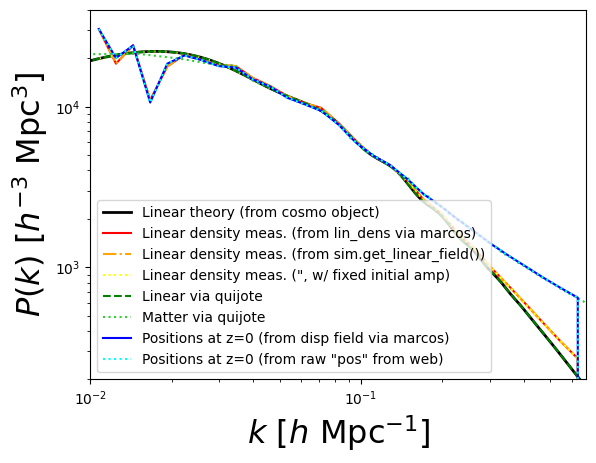

In [52]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr

ax.plot(k_lin_theory, pk_lin_theory, label='Linear theory (from cosmo object)', 
         color='k', lw=2)
ax.plot(pk_obj_denslin['k'], pk_obj_denslin['pk'], label='Linear density meas. (from lin_dens via marcos)', 
         color='red', ls='-')
ax.plot(pk_obj_denslin['k'], pk_obj_denslin['pk'], label='Linear density meas. (from sim.get_linear_field())', 
         color='orange', ls='-.')
ax.plot(pk_obj_denslin_fixed['k'], pk_obj_denslin_fixed['pk'], label='Linear density meas. (", w/ fixed initial amp)', 
         color='yellow', ls=':')
ax.plot(k_lin_z0, pk_lin_z0_norm, label='Linear via quijote', 
         color='green', ls='--')
ax.plot(pk_nl_z0[:,0], pk_nl_z0[:,1], label='Matter via quijote', 
         color='limegreen', ls=':')
ax.plot(pk_obj_pos['k'], pk_obj_pos['pk'], label='Positions at z=0 (from disp field via marcos)', 
         color='blue')
ax.plot(pk_obj_pos_raw['k'], pk_obj_pos_raw['pk'], label='Positions at z=0 (from raw "pos" from web)', 
         color='cyan', ls=':')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xlim(k_min, k_max)
plt.ylim(2e2, 4e4)

plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
plt.ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

In [53]:
# X Values
ks = [
    k_lin_theory,
    pk_obj_denslin['k'],
    pk_obj_denslin['k'],
    pk_obj_denslin_fixed['k'],
    k_lin_z0,
    pk_nl_z0[:, 0],
    pk_obj_pos['k'],
    pk_obj_pos_raw['k']
]

# Y Values
pks = [
    pk_lin_theory,
    pk_obj_denslin['pk'],
    pk_obj_denslin['pk'],
    pk_obj_denslin_fixed['pk'],
    pk_lin_z0_norm,
    pk_nl_z0[:, 1],
    pk_obj_pos['pk'],
    pk_obj_pos_raw['pk']
]

# Labels
labels = [
    'Linear theory (from cosmo object)',
    'Linear density meas. (from lin_dens via marcos)',
    'Linear density meas. (from sim.get_linear_field())',
    'Linear density meas. (", w/ fixed initial amp)',
    'Linear via quijote',
    'Matter via quijote',
    'Positions at z=0 (from disp field via marcos)',
    'Positions at z=0 (from raw "pos" from web)'
]

# Kwargs
kwargs = [
    {'color': 'k', 'lw': 2},
    {'color': 'red', 'ls': '-'},
    {'color': 'orange', 'ls': '-.'},
    {'color': 'yellow', 'ls': ':'},
    {'color': 'green', 'ls': '--'},
    {'color': 'limegreen', 'ls': ':'},
    {'color': 'blue'},
    {'color': 'cyan', 'ls': ':'}
]

Text(0, 0.5, '$(P(k) - P(k)_{theory})/P(k)_{theory}$')

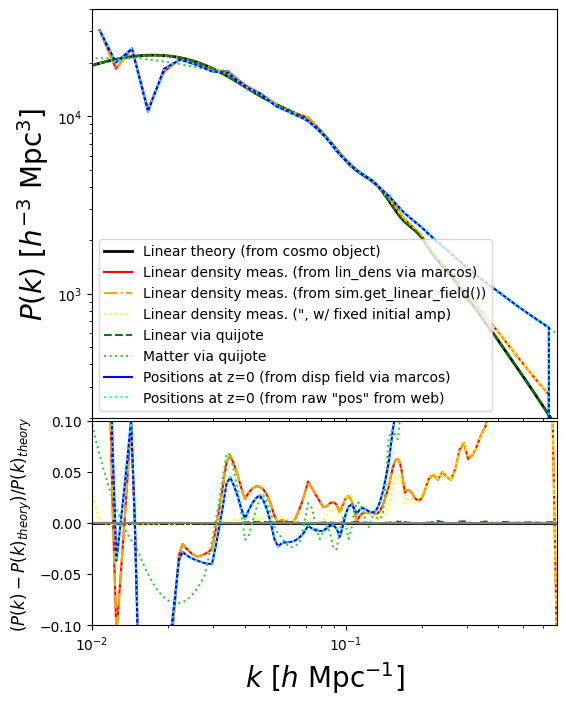

In [80]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr

i_fid = 0
pk_fid = pks[i_fid]
k_fid = ks[i_fid]

for i in range(len(pks)):
    ax.plot(ks[i], pks[i], label=labels[i], **kwargs[i])
    
    if len(pk_fid)!=len(pks[i]):
        pk_interp = np.interp(k_fid, ks[i], pks[i])
        ax1.plot(k_fid, (pk_interp-pk_fid)/pk_fid, **kwargs[i])
    else:
        ax1.plot(ks[i], (pks[i]-pk_fid)/pk_fid, **kwargs[i])
        
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(k_min, k_max)
ax.set_ylim(2e2, 4e4)
ax1.set_ylim(-0.1, 0.1)

ax1.axhline(0, color='grey', ls='-')

ax1.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=20)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=20)
ax1.set_ylabel(r'$(P(k) - P(k)_{theory})/P(k)_{theory}$', fontsize=12)

In [83]:
disp.shape

(3, 512, 512, 512)

(array([5.2000000e+01, 2.0700000e+02, 8.1700000e+02, 2.9120000e+03,
        1.0545000e+04, 3.6513000e+04, 1.1423400e+05, 3.1701300e+05,
        8.0124800e+05, 1.8516660e+06, 3.8480270e+06, 7.0780540e+06,
        1.1356197e+07, 1.5893322e+07, 1.9387172e+07, 2.0415467e+07,
        1.8114612e+07, 1.4146168e+07, 9.6882510e+06, 5.8093490e+06,
        3.0507370e+06, 1.4024590e+06, 5.7525100e+05, 2.1217200e+05,
        7.3195000e+04, 2.3317000e+04, 6.5380000e+03, 1.7320000e+03,
        4.1700000e+02, 8.4000000e+01]),
 array([-32.26550293, -30.15900421, -28.0525074 , -25.94600868,
        -23.83950996, -21.73301125, -19.62651443, -17.52001572,
        -15.413517  , -13.30701923, -11.20052052,  -9.09402275,
         -6.98752451,  -4.88102627,  -2.77452803,  -0.66802979,
          1.43846846,   3.5449667 ,   5.65146494,   7.75796318,
          9.86446095,  11.97095966,  14.07745743,  16.18395615,
         18.29045486,  20.39695168,  22.50345039,  24.60994911,
         26.71644783,  28.82294464, 

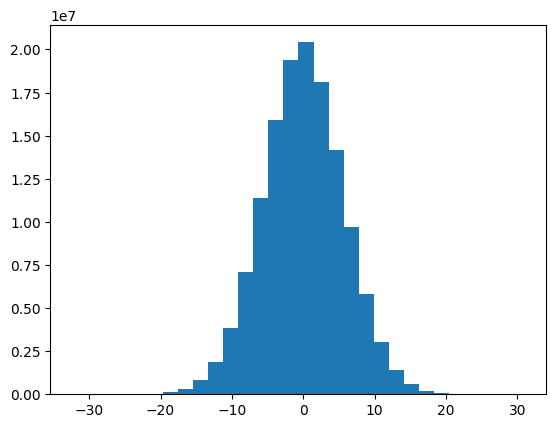

In [86]:
plt.hist(disp[2].flatten(), bins=30)